In [1]:
import os 
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from Code_manual import Coxnnet, PartialNLL
from lifelines.utils import concordance_index
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'd:\\Survival Analysis\\Cox-nnet'

Load KIRC data

In [3]:
expr_data = pd.read_table("./KIRC_expr.tsv", header=None)

time_data = pd.read_table("./KIRC_time.tsv", header=None)

observed_data = pd.read_table("./KIRC_event.tsv", header=None)

map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [4]:
X = torch.tensor(np.array(expr_data), dtype=torch.float)
time = torch.tensor(time_data.to_numpy(), dtype=torch.long)
observed = torch.tensor(observed_data.to_numpy(), dtype=torch.float)

train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=42)

train_X = X[train_idx,:]
test_X = X[test_idx,:]

train_time = time[train_idx]
test_time = time[test_idx]

train_observed = observed[train_idx]
test_observed = observed[test_idx]

In [5]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')

Train & Test

In [6]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

class TrainDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor(train_X, device=device)
        self.time_data = torch.tensor(train_time, device=device)
        self.observed_data = torch.tensor(train_observed, device=device)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        time = torch.tensor(self.time_data[index]).clone().detach()
        observed = torch.tensor(self.observed_data[index]).clone().detach()
        return x, time, observed
    
class TestDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor(test_X, device=device)
        self.time_data = torch.tensor(test_time, device=device)
        self.observed_data = torch.tensor(test_observed, device=device)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x_data[index]).clone().detach()
        time = torch.tensor(self.time_data[index]).clone().detach()
        observed = torch.tensor(self.observed_data[index]).clone().detach()
        return x, time, observed
    
training_data = TrainDataset()
test_data = TestDataset()

train_dataloader = DataLoader(training_data, batch_size = training_data.__len__())
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__())

C:\Users\dmcb\AppData\Local\Temp\ipykernel_8408\655114107.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_data = torch.tensor(train_X, device=device)
C:\Users\dmcb\AppData\Local\Temp\ipykernel_8408\655114107.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.time_data = torch.tensor(train_time, device=device)
C:\Users\dmcb\AppData\Local\Temp\ipykernel_8408\655114107.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.observed_data = torch.tensor(train_observed, device=device)
C:\Users\dmcb\AppData\Local\Temp\ipyker

In [9]:
acc = []

hidden_dim = 500
model = Coxnnet(train_X.shape[1], hidden_dim)
model = model.to(device)
learning_rate = 3e-5
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = PartialNLL()

def train_loop(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    for batch, (X, time, observed) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, time, observed)

        # Backpropagation
        optimizer.zero_grad()   # bc/ gradients by default add up; to prevent double counting.
        loss.backward() # deposits gradients
        optimizer.step()    # adjust parameters with gradients
        
        train_perf = 0
        train_perf = concordance_index(event_times = time.cpu().detach().numpy(),
                                       event_observed = observed.cpu().detach().numpy(),
                                       predicted_scores = -pred.cpu().detach().numpy())
        
        if ((t+1) % 25 == 0):
            print(f"Epoch {t+1}\n-------------------------------")
            print(f"Train Accuracy: {train_perf}\n")

# iterate over test dataset to check model performance
def test_loop(dataloader, model, t):
    size = len(dataloader.dataset)
    test_perf = 0

    with torch.no_grad():
        for X, time, observed in dataloader:
            pred = model.forward(X)
            test_perf = concordance_index(event_times = time.cpu().detach().numpy(),
                                          event_observed = observed.cpu().detach().numpy(),
                                          predicted_scores = -pred.cpu().detach().numpy())

    if ((t+1) % 25 == 0):
        print(f"Test Accuracy: {test_perf}\n")
    if (t == epochs - 1):
        acc.append(float(test_perf))

In [10]:
for i in range(10):
    print(f"------------\nReplicate {i+1}\n------------")
    train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=i)

    train_X = X[train_idx,:]
    test_X = X[test_idx,:]

    train_time = time[train_idx]
    test_time = time[test_idx]

    train_observed = observed[train_idx]
    test_observed = observed[test_idx]
    model = Coxnnet(train_X.shape[1], hidden_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        test_loop(test_dataloader, model, t)

------------
Replicate 1
------------


C:\Users\dmcb\AppData\Local\Temp\ipykernel_8408\655114107.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.x_data[index]).clone().detach()
C:\Users\dmcb\AppData\Local\Temp\ipykernel_8408\655114107.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time = torch.tensor(self.time_data[index]).clone().detach()
C:\Users\dmcb\AppData\Local\Temp\ipykernel_8408\655114107.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observed = torch.tensor(self.observed_data[index]).clone().detach()
C:\Users\dmcb\AppData\Local\T

Epoch 25
-------------------------------
Train Accuracy: 0.7265781649726889

Test Accuracy: 0.534655489674913

Epoch 50
-------------------------------
Train Accuracy: 0.7538200926502109

Test Accuracy: 0.604784297689634

Epoch 75
-------------------------------
Train Accuracy: 0.7925741547396805

Test Accuracy: 0.6107135555101206

Epoch 100
-------------------------------
Train Accuracy: 0.8121067551683606

Test Accuracy: 0.6027397260273972

------------
Replicate 2
------------
Epoch 25
-------------------------------
Train Accuracy: 0.7212542349443407

Test Accuracy: 0.6219586996524228

Epoch 50
-------------------------------
Train Accuracy: 0.7522298278365485

Test Accuracy: 0.5317930893477817

Epoch 75
-------------------------------
Train Accuracy: 0.7987969300974902

Test Accuracy: 0.595379268043345

Epoch 100
-------------------------------
Train Accuracy: 0.8369632856253889

Test Accuracy: 0.5540789204661624

------------
Replicate 3
------------
Epoch 25
--------------------

In [ ]:
print(acc)

[0.583929666734819, 0.5798405234103455, 0.6037620118585156, 0.6260478429768963, 0.5348599468411368, 0.6297280719689226, 0.6078511551829892, 0.5685953792680434, 0.6567164179104478, 0.617460641995502]


In [ ]:
KIRC_acc = acc

Load LAML data & train

In [ ]:
expr_data = pd.read_table("./LAML_expr.tsv", header=None)

time_data = pd.read_table("./LAML_time.tsv", header=None)

observed_data = pd.read_table("./LAML_event.tsv", header=None)

map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [ ]:
acc = []

for i in range(10):
    print(f"------------\nReplicate {i+1}\n------------")
    train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=i)

    train_X = X[train_idx,:]
    test_X = X[test_idx,:]

    train_time = time[train_idx]
    test_time = time[test_idx]

    train_observed = observed[train_idx]
    test_observed = observed[test_idx]
    model = Coxnnet(train_X.shape[1], hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        test_loop(test_dataloader, model, t)

------------
Replicate 1
------------
Epoch 25
-------------------------------
Train Accuracy: 0.6914540551752748

Test Accuracy: 0.5266816601921898

Epoch 50
-------------------------------
Train Accuracy: 0.7529212473207495

Test Accuracy: 0.5395624616642813

Epoch 75
-------------------------------
Train Accuracy: 0.7995920625043214

Test Accuracy: 0.6158249846657126

Epoch 100
-------------------------------
Train Accuracy: 0.7812003042245731

Test Accuracy: 0.6311592721324882

------------
Replicate 2
------------
Epoch 25
-------------------------------
Train Accuracy: 0.7019636313351311

Test Accuracy: 0.5667552647720303

Epoch 50
-------------------------------
Train Accuracy: 0.7637765332227062

Test Accuracy: 0.5655285217746882

Epoch 75
-------------------------------
Train Accuracy: 0.8044319988937289

Test Accuracy: 0.6062154978531997

Epoch 100
-------------------------------
Train Accuracy: 0.8329876235912328

Test Accuracy: 0.5865876098957269

------------
Replicate 3
-

In [ ]:
LAML_acc = acc

Load PAAD data & train

In [ ]:
expr_data = pd.read_table("./PAAD_expr.tsv", header=None)

time_data = pd.read_table("./PAAD_time.tsv", header=None)

observed_data = pd.read_table("./PAAD_event.tsv", header=None)

map_dict = {'DECEASED' : 1,
            'LIVING' : 0}
observed_data = observed_data[0].apply(lambda x : map_dict[x])

In [ ]:
acc = []

for i in range(10):
    print(f"------------\nReplicate {i+1}\n------------")
    train_idx, test_idx, _, _ = train_test_split(np.arange(X.shape[0]), observed, test_size=0.3, random_state=i)

    train_X = X[train_idx,:]
    test_X = X[test_idx,:]

    train_time = time[train_idx]
    test_time = time[test_idx]

    train_observed = observed[train_idx]
    test_observed = observed[test_idx]
    model = Coxnnet(train_X.shape[1], hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        model.train()
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        model.eval()
        test_loop(test_dataloader, model, t)
        
PAAD_acc = acc

------------
Replicate 1
------------


KeyboardInterrupt: 

Average of accuracy per data

In [ ]:
print(f"Average of KIRC acc : {sum(KIRC_acc)/len(KIRC_acc)}")
print(f"Average of LAML acc : {sum(LAML_acc)/len(LAML_acc)}")
print(f"Average of PAAD acc : {sum(PAAD_acc)/len(PAAD_acc)}")

Average of KIRC acc : 0.6008791658147619
Average of LAML acc : 0.6073809037006749
Average of PAAD acc : 0.6154160703332651


Boxplot

<function matplotlib.pyplot.show(close=None, block=None)>

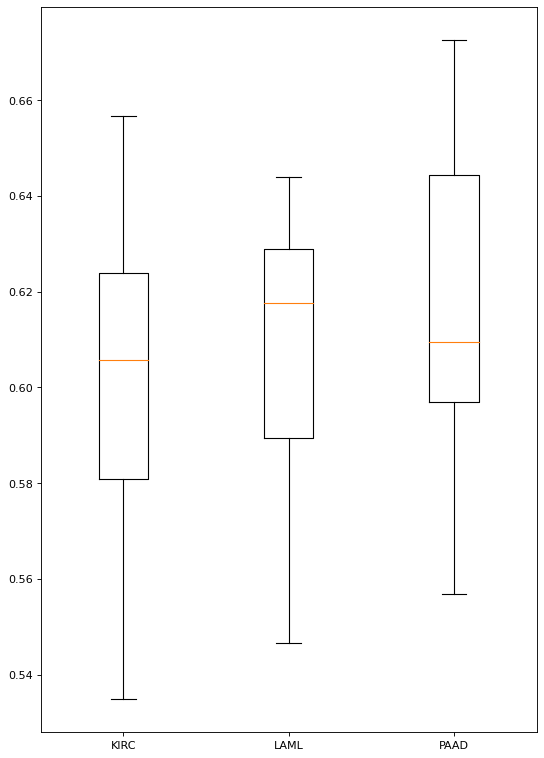

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 12), dpi=80)

data = [KIRC_acc, LAML_acc, PAAD_acc]
plt.boxplot(data, labels=['KIRC', 'LAML', 'PAAD'])
plt.show